<a href="https://colab.research.google.com/github/Mahedi-Shuvro/seismic-velocity-inversion/blob/main/DeepLabV3plus_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This cell connects Colab notebook to
Google Drive for easy file access and storage.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Section 1: Imports and Configuration

> Loads all the necessary libraries for operations such as file handling, data loading, training, evaluation, visualization, and utility functions to support model development.



In [2]:
!pip install anytree                                                  # for creating and manipulating tree data structures in Python.

import os                                                             # for file and path handling
import numpy as np                                                    # Numerical computations.
import matplotlib.pyplot as plt                                       # Data visualization
from glob import glob                                                 # Progress bars for loops.
from tqdm import tqdm
#Deep learning framework and essential modules (layers, functions, optimizers).
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split                  # Splitting dataset into training and testing subsets.
from utils import create_submission, calculate_mape, calculate_score  # Custom Utilities (Project-Specific-given)
from IPython.display import FileLink                                  # To allow file download links (for submissions or outputs).

# Data Analysis & Inspection

This cell ensures that train and test datasets are unzipped and ready in the Colab environment, and prints a few file names to verify everything’s in place.

In [3]:
import zipfile
import os

def extract_zip(zip_path, extract_path):
    """Extracts a zip file to a given directory if not already extracted."""
    os.makedirs(extract_path, exist_ok=True)

    # Check if the directory is already populated
    if os.listdir(extract_path):
        print(f"✅ Data already extracted at: {extract_path}")
        return

    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
        print(f"✅ Extraction complete. Files extracted to: {extract_path}")
    except zipfile.BadZipFile:
        print(f"❌ Error: The zip file at {zip_path} is corrupted.")
    except FileNotFoundError:
        print(f"❌ Error: Zip file not found at {zip_path}.")

# File paths
train_zip = "/content/drive/MyDrive/Speed_and_Structure/speed-and-structure-train-data.zip"
train_extract = "/content/sample_data/speed-and-structure-train"

test_zip = "/content/drive/MyDrive/Speed_and_Structure/speed-and-structure-test-data.zip"
test_extract = "/content/sample_data/speed-and-structure-test"

# Extract datasets if not already extracted
extract_zip(train_zip, train_extract)
extract_zip(test_zip, test_extract)

# Optional: Show sample files to confirm
print("📂 Sample training files:", os.listdir(train_extract)[:5])
print("📂 Sample testing files:", os.listdir(test_extract)[:5])

✅ Data already extracted at: /content/sample_data/speed-and-structure-train
✅ Data already extracted at: /content/sample_data/speed-and-structure-test
📂 Sample training files: ['99E04MfnA1qDGJDuHQ', 'f7I4IEP4Bu9JZjINVE', 'wGlBlixO7tMyHnkbmw', '76uJNPvwxYX90nUGQh', 'PMZqQR8vj2q3aBKYwK']
📂 Sample testing files: ['ZbaNI3NfFm8moPSseW', 'ckXxcOZTl56w0M4AqQ', 'uUdcmWSzQP34SqxGSq', 'JiMYsgbyDFKSXMl2iz', 'wj5vjgnGUWv16GBmVQ']


Counts the total number of training samples (folders). Inspects the first sample to:

Load and check the shapes and data types for 5 key input files (receiver_data_src_*.npy).

Load the ground truth velocity model (vp_model.npy).

Verifies that the dataset is structured and loaded correctly before proceeding to data loading or model training.

>
First sample inspected: 00ady8InZofxhWZsDT

All 5 receiver data files (receiver_data_src_*.npy) were loaded successfully.

Shape: (10001, 31)

Data type: float32

Ground truth velocity model (vp_model.npy) loaded successfully.

Shape: (300, 1259)

Data type: float64

This confirms that both input data and target labels are present and correctly formatted for this sample.

In [4]:
# Path to training samples
train_dir = "/content/sample_data/speed-and-structure-train"
sample_folders = sorted([f for f in glob(os.path.join(train_dir, "*")) if os.path.isdir(f)])
print(f"📦 Total training samples: {len(sample_folders)}")

# Pick one to inspect
sample_path = sample_folders[0]
sample_id = os.path.basename(sample_path)
print(f"\n🔍 Inspecting sample: {sample_id}")

# Load all 5 receiver data inputs
receiver_indices = [1, 75, 150, 225, 300]
for i in receiver_indices:
    file_path = os.path.join(sample_path, f"receiver_data_src_{i}.npy")
    try:
        data = np.load(file_path)
        print(f"Loaded: receiver_data_src_{i}.npy - shape: {data.shape}, dtype: {data.dtype}")
    except FileNotFoundError:
        print(f"Missing file: receiver_data_src_{i}.npy")

# Load the velocity model
vp_path = os.path.join(sample_path, "vp_model.npy")
try:
    vp_model = np.load(vp_path)
    print(f"\n✅ Loaded: vp_model.npy - shape: {vp_model.shape}, dtype: {vp_model.dtype}")
except FileNotFoundError:
   print("Missing file: vp_model.npy")

📦 Total training samples: 2000

🔍 Inspecting sample: 00ady8InZofxhWZsDT
Loaded: receiver_data_src_1.npy - shape: (10001, 31), dtype: float32
Loaded: receiver_data_src_75.npy - shape: (10001, 31), dtype: float32
Loaded: receiver_data_src_150.npy - shape: (10001, 31), dtype: float32
Loaded: receiver_data_src_225.npy - shape: (10001, 31), dtype: float32
Loaded: receiver_data_src_300.npy - shape: (10001, 31), dtype: float32

✅ Loaded: vp_model.npy - shape: (300, 1259), dtype: float64


**visualize both the seismic input data and the ground truth velocity model for a given sample folder.**

Function: visualize_sample(sample_path)


Steps:
Loads 5 receiver input files

*   (receiver_data_src_{src}.npy) for sources at positions 1, 75, 150, 225, and 300, with error handling:
*   If a file is missing or there’s an error, a zero placeholder array is used instead.

* Loads the ground truth velocity model (vp_model.npy) for the sample, with error handling.

* Plots the 5 receiver data arrays side-by-side using matplotlib (each as an image, with “seismic” color map).

* Plots the velocity model as an image (with “viridis” color map), showing how velocity varies with depth and distance.

* Runs the visualization on the first training sample:
sample_folders = sorted(glob("/content/sample_data/speed-and-structure-train/*"))  . visualize_sample(sample_folders[0])

🔍 Visualizing sample at: 00ady8InZofxhWZsDT


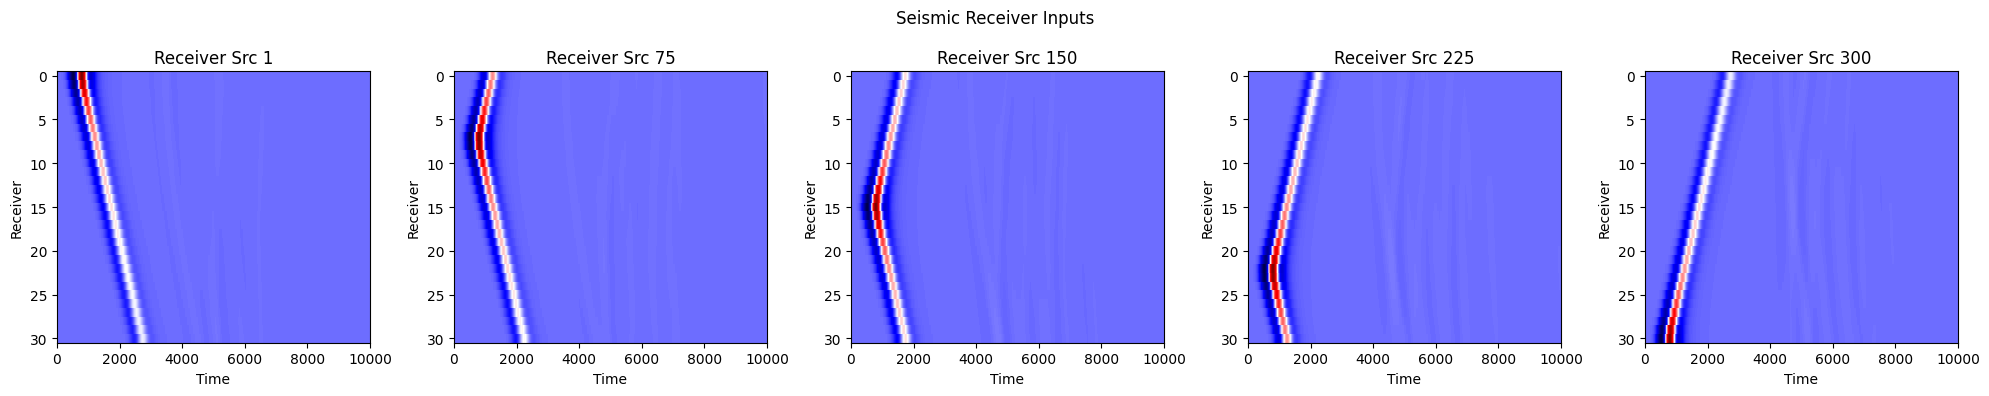

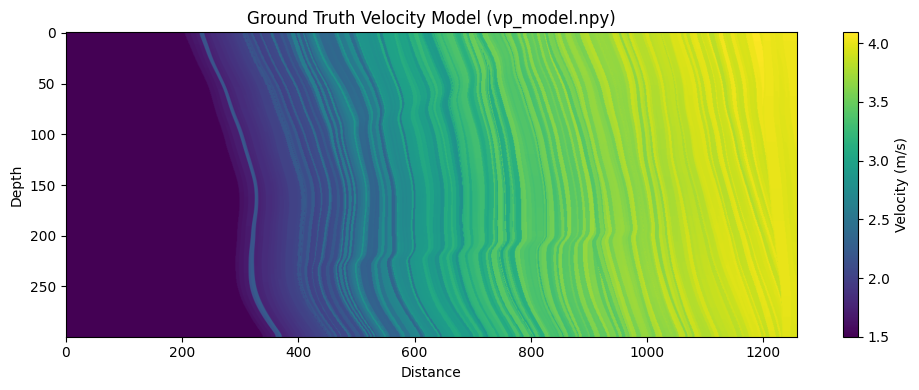

In [5]:
def visualize_sample(sample_path):
    source_positions = [1, 75, 150, 225, 300]
    receiver_data = []

    print(f"🔍 Visualizing sample at: {os.path.basename(sample_path)}")

    # Load seismic receiver inputs with error handling
    for src in source_positions:
        file_path = os.path.join(sample_path, f"receiver_data_src_{src}.npy")
        try:
            data = np.load(file_path)
            receiver_data.append(data)
        except FileNotFoundError:
            print(f"File not found: {file_path}")
            receiver_data.append(np.zeros((100, 100)))  # placeholder
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
            receiver_data.append(np.zeros((100, 100)))  # placeholder

    # Load velocity model
    try:
        vp_model = np.load(os.path.join(sample_path, "vp_model.npy"))
    except FileNotFoundError:
        print("vp_model.npy not found!")
        return
    except Exception as e:
        print(f"Error loading vp_model.npy: {e}")
        return

    # Plot seismic receiver inputs
    fig, axs = plt.subplots(1, 5, figsize=(20, 4))
    for i, (data, src) in enumerate(zip(receiver_data, source_positions)):
        axs[i].imshow(data.T, aspect='auto', cmap='seismic', interpolation='none')
        axs[i].set_title(f"Receiver Src {src}")
        axs[i].set_xlabel("Time")
        axs[i].set_ylabel("Receiver")
    plt.suptitle("Seismic Receiver Inputs")
    plt.tight_layout()
    plt.show()

    # Plot velocity model
    plt.figure(figsize=(10, 4))
    plt.imshow(vp_model, aspect='auto', cmap='viridis')
    plt.title("Ground Truth Velocity Model (vp_model.npy)")
    plt.xlabel("Distance")
    plt.ylabel("Depth")
    plt.colorbar(label='Velocity (m/s)')
    plt.tight_layout()
    plt.show()


sample_folders = sorted(glob("/content/sample_data/speed-and-structure-train/*"))
visualize_sample(sample_folders[0])



**INSPECT TEST DATA ** the total number of test samples (folders) in the test dataset.

Inspects the first test sample:

Loads and prints the shape and data type for each of the 5 receiver input files (receiver_data_src_*.npy).

Verifies that all necessary input files are present and correctly formatted.

Confirms the test dataset is ready for inference (no ground truth velocity model in test set)

In [6]:
import os
import numpy as np
from glob import glob

# Path to test samples
test_dir = "/content/sample_data/speed-and-structure-test"
test_folders = sorted([f for f in glob(os.path.join(test_dir, "*")) if os.path.isdir(f)])
print(f"🧪 Total test samples: {len(test_folders)}")

# Pick one to inspect
test_sample_path = test_folders[0]
test_sample_id = os.path.basename(test_sample_path)
print(f"\n🔍 Inspecting test sample: {test_sample_id}")

# Load receiver data (no velocity ground truth in test set)
receiver_indices = [1, 75, 150, 225, 300]
for i in receiver_indices:
    file_path = os.path.join(test_sample_path, f"receiver_data_src_{i}.npy")
    try:
        test_data = np.load(file_path)
        print(f"Loaded: receiver_data_src_{i}.npy - shape: {test_data.shape}, dtype: {test_data.dtype}")
    except FileNotFoundError:
        print(f"Missing file: receiver_data_src_{i}.npy")
    except Exception as e:
        print(f"Error loading receiver_data_src_{i}.npy: {e}")


🧪 Total test samples: 150

🔍 Inspecting test sample: 0BFqBxnVIT368FwmdR
Loaded: receiver_data_src_1.npy - shape: (10001, 31), dtype: float32
Loaded: receiver_data_src_75.npy - shape: (10001, 31), dtype: float32
Loaded: receiver_data_src_150.npy - shape: (10001, 31), dtype: float32
Loaded: receiver_data_src_225.npy - shape: (10001, 31), dtype: float32
Loaded: receiver_data_src_300.npy - shape: (10001, 31), dtype: float32


# Data preparation for Training
* Defines a PyTorch dataset class for seismic data.

* Each sample contains 5 receiver data inputs, resized to shape (5, 300, 1259).

* For training/validation: returns both inputs and ground truth velocity model.

* For test data: returns only inputs and sample ID (no ground truth).

* Enables efficient loading and batching for deep learning workflows.

In [7]:
import torch
from torch.utils.data import Dataset
import numpy as np
from glob import glob
import torch.nn.functional as F
import os

class SeismicDataset(Dataset):
    def __init__(self, root, is_test=False):
        self.paths = sorted(glob(os.path.join(root, "*")))
        self.is_test = is_test
        self.src_pos = [1, 75, 150, 225, 300]

        # Target padded size (must be divisible by 16)
        self.pad_h = 304
        self.pad_w = 1264

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, i):
        folder = self.paths[i]
        x = np.stack([
            np.load(os.path.join(folder, f"receiver_data_src_{p}.npy"))
            for p in self.src_pos
        ]).astype(np.float32)

        x = torch.from_numpy(x).unsqueeze(0)  # (1, 5, H, W)
        x = F.interpolate(x, size=(300, 1259), mode='bilinear').squeeze(0)  # (5, 300, 1259)

        # Calculate padding sizes
        pad_h = self.pad_h - x.shape[1]  # 4
        pad_w = self.pad_w - x.shape[2]  # 5

        # Pad input tensor: pad format (left, right, top, bottom)
        x = F.pad(x, (0, pad_w, 0, pad_h))

        if self.is_test:
            return x, os.path.basename(folder)

        y = torch.from_numpy(np.load(os.path.join(folder, "vp_model.npy")).astype(np.float32))
        y = F.pad(y, (0, pad_w, 0, pad_h))

        return x, y



In [8]:
full_dataset = SeismicDataset(train_dir)
sample = full_dataset[0][0]
print("Sample input shape after padding:", sample.shape)

Sample input shape after padding: torch.Size([5, 304, 1264])


* Sets up training, validation, and test datasets using the custom SeismicDataset class.

* Randomly splits the training data into 80% for training and 20% for validation.

* Creates PyTorch DataLoaders for batching and efficient data feeding during model training and evaluation.

* Test DataLoader uses test mode (no ground truth labels)

In [9]:
#  Data Setup
train_dir = "/content/sample_data/speed-and-structure-train"
test_dir = "/content/sample_data/speed-and-structure-test"

full_dataset = SeismicDataset(train_dir)
train_idx, val_idx = train_test_split(np.arange(len(full_dataset)), test_size=0.2, random_state=42)

train_loader = DataLoader(Subset(full_dataset, train_idx), batch_size=2, shuffle=True)
val_loader = DataLoader(Subset(full_dataset, val_idx), batch_size=1)
test_loader = DataLoader(SeismicDataset(test_dir, is_test=True), batch_size=1)

# Model Defination & Training

In [10]:
!pip install segmentation-models-pytorch --quiet

In [11]:
from segmentation_models_pytorch import DeepLabV3Plus
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = DeepLabV3Plus(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=5,
    classes=1,
    activation=None
).to(device)


Using device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [12]:
class MAPELoss(torch.nn.Module):
    def __init__(self, epsilon=1e-5):
        super().__init__()
        self.epsilon = epsilon
    def forward(self, pred, target):
        return torch.mean(torch.abs((target - pred) / (target + self.epsilon)))

criterion = MAPELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)


In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Assuming model, criterion, optimizer, train_loader, val_loader, device are already defined

num_epochs = 10
best_val_loss = float('inf')
history = {"train_loss": [], "val_loss": []}

for epoch in range(num_epochs):
    model.train()
    train_losses = []
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()

        preds = model(x).squeeze(1)  # preds shape: (B, 304, 1264)

        # Crop predictions and labels to original size
        preds_cropped = preds[:, :300, :1259]
        y_cropped = y[:, :300, :1259]

        loss = criterion(preds_cropped, y_cropped)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    history["train_loss"].append(train_loss)

    model.eval()
    val_losses = []
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            preds = model(x).squeeze(1)

            preds_cropped = preds[:, :300, :1259]
            y_cropped = y[:, :300, :1259]

            loss = criterion(preds_cropped, y_cropped)
            val_losses.append(loss.item())

    val_loss = np.mean(val_losses)
    history["val_loss"].append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.5f} | Val Loss: {val_loss:.5f}")

    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_deeplabv3plus_model.pth")
        print("✅ Saved new best model!")

# Plot training and validation loss
plt.figure(figsize=(8, 5))
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MAPE Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

Epoch 1/10 | Train Loss: 0.12490 | Val Loss: 0.05425
✅ Saved new best model!


KeyboardInterrupt: 

# Evaluation

In [14]:
import os
import numpy as np
import torch

# Ensure predictions directory exists
os.makedirs("/content/predictions", exist_ok=True)

model.eval()  # Set to evaluation mode

results = {}

with torch.no_grad():
    for x, sample_id in test_loader:
        x = x.to(device)

        preds = model(x).squeeze(1)  # Shape: (B, 304, 1264)

        # Crop to original size (300, 1259)
        preds_cropped = preds[:, :300, :1259]

        # Move to CPU and convert to numpy
        preds_np = preds_cropped.cpu().numpy()[0]

        # Store or save prediction
        results[sample_id[0]] = preds_np
        np.save(f"/content/predictions/{sample_id[0]}_pred.npy", preds_np)

print("✅ Test predictions generated and saved.")

✅ Test predictions generated and saved.


Evaluating MAPE:   0%|          | 0/400 [00:00<?, ?it/s]/tmp/ipython-input-2969976315.py:4: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
Evaluating MAPE: 100%|██████████| 400/400 [00:09<00:00, 41.82it/s]


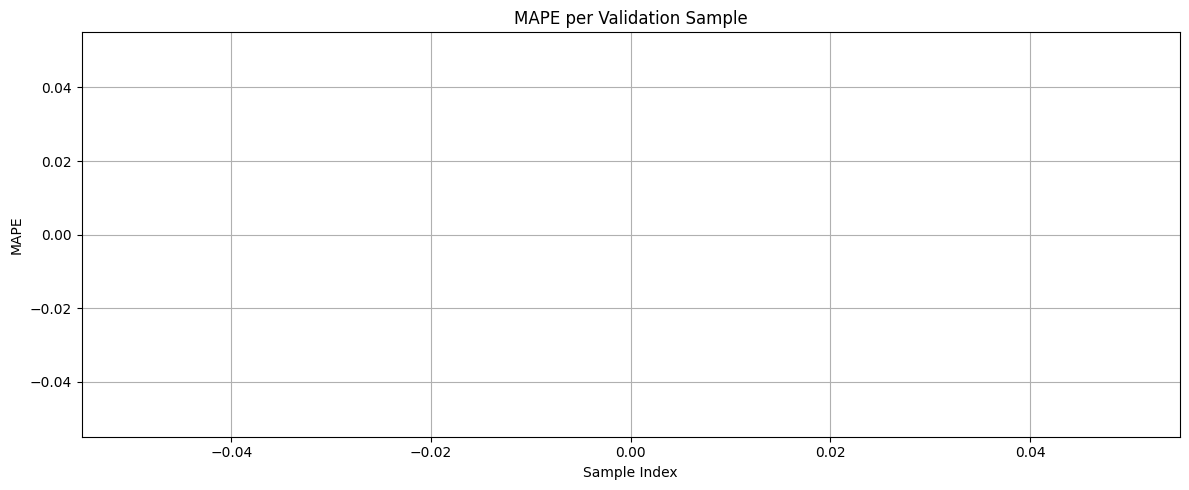

📊 Mean Validation MAPE: inf
   sample_index  mape
0          1860   inf
1           353   inf
2          1333   inf
3           905   inf
4          1289   inf


In [15]:
import pandas as pd

def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
def evaluate_per_sample(model, dataset, indices, device):
    model.eval()
    mape_records = []

    with torch.no_grad():
        for idx in tqdm(indices, desc="Evaluating MAPE"):
            x, y_true = dataset[idx]
            x = x.unsqueeze(0).to(device)
            y_true_np = y_true.numpy()

            y_pred = model(x).squeeze(0).cpu().numpy()
            mape = calculate_mape(y_true_np, y_pred)

            mape_records.append({
                "sample_index": idx,
                "mape": mape
            })

    return pd.DataFrame(mape_records)

# Evaluate on validation set
val_df = evaluate_per_sample(model, full_dataset, val_idx, device)

# 📈 Plot MAPE per sample
plt.figure(figsize=(12, 5))
plt.plot(val_df["sample_index"], val_df["mape"], marker='o', linestyle='-', alpha=0.7)
plt.title("MAPE per Validation Sample")
plt.xlabel("Sample Index")
plt.ylabel("MAPE")
plt.grid(True)
plt.tight_layout()
plt.show()

# Print average MAPE
mean_val_mape = val_df["mape"].mean()
print(f"📊 Mean Validation MAPE: {mean_val_mape:.6f}")

# Save to CSV
val_df.to_csv("/content/validation_mape_per_sample.csv", index=False)

# Reload and inspect
import pandas as pd
csv_path = "/content/validation_mape_per_sample.csv"
df = pd.read_csv(csv_path)
print(df.head())

# Submission

In [18]:
import os
from tqdm import tqdm
from IPython.display import FileLink

submission_path = "/content/speed_structure_submission.npz"
if os.path.exists(submission_path):
    os.remove(submission_path)

model.eval()
with torch.no_grad():
    for x, sample_id in tqdm(test_loader):
        x = x.to(device)

        pred = model(x).squeeze(1)  # remove channel dim, shape (1, H, W)

        # Crop to original size (300, 1259)
        pred_cropped = pred[:, :300, :1259]

        # Convert to numpy array (remove batch dim)
        pred_np = pred_cropped.cpu().numpy()[0].astype(np.float64)

        # Add prediction to submission file
        create_submission(sample_id[0], pred_np, submission_path)

# Provide a download link for the submission file
FileLink(submission_path)

100%|██████████| 150/150 [02:36<00:00,  1.05s/it]


/content/speed_structure_submission.npz

In [19]:
## ✅ Section 7: Submission Sanity Check
def validate_submission_file(sub_path, expected=150):
    if not os.path.exists(sub_path): return print("❌ File missing")
    data = np.load(sub_path); keys = list(data.keys())
    print(f"✅ {len(keys)} predictions found.")
    bad = [(k, v.shape, v.dtype) for k, v in data.items() if v.shape != (300,1259) or v.dtype != np.float64]
    if bad:
        print(f"⚠️ {len(bad)} bad entries:", bad[:3])
    else:
        print("🏁 Submission looks good!")

validate_submission_file(submission_path)

✅ 150 predictions found.
🏁 Submission looks good!
